In [1]:
!pip install pyro-ppl 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.7/722.7 kB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 MB 7.7 MB/s eta 0:00:0000:0100:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [2]:
import matplotlib.pyplot as plt
import torch
import pyro
from pyro.distributions import Normal, Delta
from pyro.infer.autoguide.guides import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.predictive import Predictive

/Users/umedayusuke/workspace/baysian/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 変分推論

In [3]:
# =============================
# ニューラルネットワークモデル
# =============================
class BNN(object):
    def __init__(self, input_size, hidden_size, output_size, w_sigma, y_sigma):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w_sigma = w_sigma
        self.y_sigma = y_sigma

    def model(self, x_data, y_data):
        # パラメータの生成
        with pyro.plate("w1_plate_dim2", self.hidden_size):
            with pyro.plate("w1_plate_dim1", self.input_size):
                w1 = pyro.sample("w1", Normal(0, self.w_sigma))
        with pyro.plate("w2_plate_dim2", self.output_size):
            with pyro.plate("w2_plate_dim1", self.hidden_size):
                w2 = pyro.sample("w2", Normal(0, self.w_sigma))

        f = lambda x: torch.mm(torch.tanh(torch.mm(x, w1)), w2)
        # 観測データの生成
        with pyro.plate("map", len(x_data)):
            prediction_mean = f(x_data).squeeze()
            pyro.sample("obs", Normal(prediction_mean, self.y_sigma), obs=y_data)
            return prediction_mean

    def VI(self, x_data, y_data, num_samples=1000, num_iterations=30000):
        self.guide = AutoDiagonalNormal(self.model)
        optim = Adam({"lr": 1e-3})
        loss = Trace_ELBO()
        svi = SVI(self.model, self.guide, optim=optim, loss=loss)

        # train
        pyro.clear_param_store()
        for j in range(num_iterations):
            loss = svi.step(x_data, y_data)
            if j % (num_iterations // 10) == 0:
                print("[iteration %05d] loss: %.4f" % (j + 1, loss / len(x_data)))

        # num_samplesだけ事後分布からサンプルを生成
        dict = {}
        for i in range(num_samples):
            sample = self.guide()  # sampling
            for name, value in sample.items():
                if not dict.keys().__contains__(name):
                    dict[name] = value.unsqueeze(0)
                else:
                    dict[name] = torch.cat([dict[name], value.unsqueeze(0)], dim=0)
        self.posterior_samples = dict

    def predict(self, x_pred):
        def wrapped_model(x_data, y_data):
            pyro.sample("prediction", Delta(self.model(x_data, y_data)))

        predictive = Predictive(wrapped_model, self.posterior_samples)
        samples =  predictive.get_samples(x_pred, None)
        return samples["prediction"], samples["obs"]



In [4]:
H_0 = 2  # 入力次元
H_1 = 4  # 中間層のユニット数
D = 1  # 出力次元
# 訓練データセット
data = torch.tensor([[-4.5, -0.22],
                      [-4.4, -0.10],
                      [-4.0, 0.00],
                      [-2.9, -0.11],
                      [-2.7, -0.33],
                      [-1.5, -0.20],
                      [-1.3, -0.08],
                      [-0.8, -0.21],
                      [0.1, -0.34],
                      [1.5, 0.10],
                      [2.0, 0.11],
                      [2.1, 0.14],
                      [2.6, 0.21],
                      [3.5, 0.23],
                      [3.6, 0.38]])
x_data = data[:, 0].reshape(-1, 1)
x_data = torch.cat([x_data, torch.ones_like(x_data)], dim=1)  # biasごと入力に含ませる
y_data = data[:, 1]

In [5]:
# ハイパーパラメータ
w_sigma = torch.tensor(0.75)
y_sigma = torch.tensor(0.09)

In [6]:
# モデル
bnn = BNN(H_0, H_1, D, w_sigma, y_sigma)

In [7]:
# モデル
bnn = BNN(H_0, H_1, D, w_sigma, y_sigma)

In [8]:
# 推論
bnn.VI(x_data, y_data)

[iteration 00001] loss: 5.8224
[iteration 03001] loss: 1.1301
[iteration 06001] loss: 0.6383
[iteration 09001] loss: 0.4116
[iteration 12001] loss: -0.0457
[iteration 15001] loss: 0.3328
[iteration 18001] loss: 0.2086
[iteration 21001] loss: 0.1660
[iteration 24001] loss: 0.1859
[iteration 27001] loss: 0.5413


In [9]:
# 予測
x = torch.linspace(-6.0, 6.0, 1000).reshape(-1, 1)
x_new = torch.cat([x, torch.ones_like(x)], dim=1)  # 予測入力点
mu_samples, y_samples = bnn.predict(x_new)

# 結果

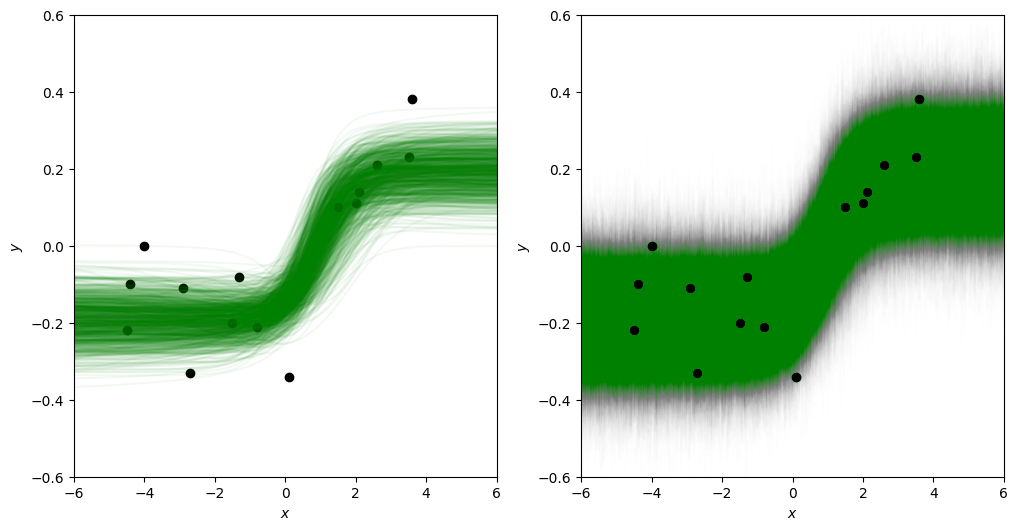

In [10]:
# 結果の図示
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for sample in mu_samples:
    ax[0].plot(x.flatten().numpy(), sample.flatten().detach().numpy(), alpha=0.05, color='g')
ax[0].scatter(x_data[:, 0].flatten().numpy(), y_data.numpy(), color="black")
ax[0].set(xlabel="$x$", ylabel="$y$", xlim=(-6.0, 6.0), ylim=(-0.6, 0.6))

for sample in y_samples:
    ax[1].plot(x.flatten().numpy(), sample.flatten().detach().numpy(), alpha=0.005, color='g')
ax[1].scatter(x_data[:, 0].flatten().numpy(), y_data.numpy(), color="black")
ax[1].set(xlabel="$x$", ylabel="$y$", xlim=(-6.0, 6.0), ylim=(-0.6, 0.6))
plt.show()

# ラプラス近似

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pyro
from pyro.distributions import Normal
from pyro.infer.autoguide.guides import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [12]:
# =============================
# ニューラルネットワークモデル
# =============================
# バイアス項なし全結合Layerを定義
class NonBiasLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(NonBiasLinear, self).__init__()
        self.weight = nn.Parameter(data=torch.randn(input_size, output_size), requires_grad=True)

    def forward(self, input_tensor):
        return torch.mm(input_tensor, self.weight)


# 2層ニューラルネットワークモデル
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = NonBiasLinear(input_size, hidden_size)
        self.fc2 = NonBiasLinear(hidden_size, output_size)

    def forward(self, x):
        output = self.fc1(x)
        output = torch.tanh(output)
        output = self.fc2(output)
        return output


# ベイズニューラルネットワークモデル
class BNN(object):
    def __init__(self, input_size, hidden_size, output_size, w_sigma, y_sigma):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.net = Net(input_size, hidden_size, output_size)
        self.w_sigma = w_sigma
        self.y_sigma = y_sigma

    def model(self, x_data, y_data):
        # 事前分布
        w1_size = (self.input_size, self.hidden_size)
        w2_size = (self.hidden_size, self.output_size)
        w1_prior = Normal(torch.zeros(size=w1_size), self.w_sigma * torch.ones(size=w1_size))
        w2_prior = Normal(torch.zeros(size=w2_size), self.w_sigma * torch.ones(size=w2_size))
        priors = {'fc1.weight': w1_prior, 'fc2.weight': w2_prior}
        # lift
        lifted_module = pyro.random_module("module", self.net, priors)
        lifted_bnn_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            prediction_mean = lifted_bnn_model(x_data).squeeze()
            pyro.sample("obs", Normal(prediction_mean, self.y_sigma), obs=y_data)
            return prediction_mean

    # MAP推定
    def MAPestimation(self, x_data, y_data, num_iterations=10000):
        guide = AutoDelta(self.model)
        svi = SVI(self.model, guide, Adam({"lr": 1e-3}), loss=Trace_ELBO())

        # train
        pyro.clear_param_store()
        for j in range(num_iterations):
            loss = svi.step(x_data, y_data)
            if j % (num_iterations // 10) == 0:
                print("[iteration %05d] loss: %.4f" % (j + 1, loss / len(x_data)))

        # MAP推定値を取得
        param_dict = {}
        for name, value in pyro.get_param_store().items():
            param_dict[name] = value.data
        w1_MAP = param_dict['auto_module$$$fc1.weight']
        w2_MAP = param_dict['auto_module$$$fc2.weight']
        self.net.fc1.weight.data = w1_MAP
        self.net.fc2.weight.data = w2_MAP
        return w1_MAP, w2_MAP

    # ヘッセ行列の計算
    def _compute_hessian(self, x_data, hessian_size):
        hessian_matrix = torch.zeros(size=(hessian_size, hessian_size))
        for x in x_data:
            x.unsqueeze_(0)
            f = self.net.forward(x)
            f.backward(retain_graph=False)
            with torch.no_grad():
                grad_w1 = self.net.fc1.weight.grad
                grad_w2 = self.net.fc2.weight.grad
                grad_f = torch.cat([grad_w1.reshape(-1, 1), grad_w2.reshape(-1, 1)], dim=0)  # 勾配(列ベクトル)の形に整形
                hessian_matrix += torch.mm(grad_f, torch.t(grad_f))
            self.net.zero_grad()  # 勾配を0に戻す
        return hessian_matrix

    # ラプラス近似分布の計算
    def LaplaceApproximation(self, x_data, y_data):
        # 平均ベクトルについて
        w1_MAP, w2_MAP = self.MAPestimation(x_data, y_data)
        W_MAP_vector = torch.cat([w1_MAP.reshape(-1, 1), w2_MAP.reshape(-1, 1)], dim=0)
        # 共分散行列について
        M = W_MAP_vector.shape[0]
        hessian_matrix = self._compute_hessian(x_data, hessian_size=M)
        lambda_matrix = (self.w_sigma ** (-2)) * torch.eye(M) + (self.y_sigma ** (-2)) * hessian_matrix
        self.lambda_mat_inv = torch.inverse(lambda_matrix)

    # 事後予測分布の計算
    def predict(self, x_pred):
        f_pred = self.net.forward(x_pred)
        f_pred.backward(retain_graph=False)
        with torch.no_grad():
            grad_w1 = self.net.fc1.weight.grad
            grad_w2 = self.net.fc2.weight.grad
            g = torch.cat([grad_w1.reshape(-1, 1), grad_w2.reshape(-1, 1)], dim=0)
            y_pred_sigma2 = self.y_sigma ** 2 + torch.mm(torch.t(g), torch.mm(self.lambda_mat_inv, g))  # 予測分散
        self.net.zero_grad()  # 勾配を0に戻す
        return f_pred, torch.sqrt(y_pred_sigma2)


In [13]:
H_0 = 2  # 入力次元
H_1 = 4  # 中間層のユニット数
D = 1  # 出力次元
# 訓練データセット
data = torch.tensor([[-4.5, -0.22],
                      [-4.4, -0.10],
                      [-4.0, 0.00],
                      [-2.9, -0.11],
                      [-2.7, -0.33],
                      [-1.5, -0.20],
                      [-1.3, -0.08],
                      [-0.8, -0.21],
                      [0.1, -0.34],
                      [1.5, 0.10],
                      [2.0, 0.11],
                      [2.1, 0.14],
                      [2.6, 0.21],
                      [3.5, 0.23],
                      [3.6, 0.38]])
x_data = data[:, 0].reshape(-1, 1)
x_data = torch.cat([x_data, torch.ones_like(x_data)], dim=1)  # biasごと入力に含ませる
y_data = data[:, 1]

In [14]:
# ハイパーパラメータ
w_sigma = torch.tensor(0.75)
y_sigma = torch.tensor(0.09)
# ネットワークモデル
bnn = BNN(H_0, H_1, D, w_sigma, y_sigma)

In [15]:
bnn.model(x_data, y_data)

/Users/umedayusuke/workspace/baysian/env/lib/python3.8/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


tensor([-2.1034, -2.0960, -2.0591, -1.8588, -1.7980, -1.1479, -0.9754, -0.4545,
         0.6135,  1.6977,  1.8795,  1.9070,  2.0117,  2.1101,  2.1167])

In [16]:
# ハイパーパラメータ
w_sigma = torch.tensor(0.75)
y_sigma = torch.tensor(0.09)
input_size = 2
hidden_size = 4
output_size =1

In [17]:
net = Net(input_size, hidden_size, output_size)

In [18]:
w1_size = (input_size, hidden_size)
w2_size = (hidden_size, output_size)
w1_prior = Normal(torch.zeros(size=w1_size), w_sigma * torch.ones(size=w1_size))
w2_prior = Normal(torch.zeros(size=w2_size), w_sigma * torch.ones(size=w2_size))
priors = {'fc1.weight': w1_prior, 'fc2.weight': w2_prior}
# lift
lifted_module = pyro.random_module("module", net, priors)
lifted_bnn_model = lifted_module()
with pyro.plate("map", len(x_data)):
    prediction_mean = lifted_bnn_model(x_data).squeeze()
    pyro.sample("obs", Normal(prediction_mean, y_sigma), obs=y_data)
    print(prediction_mean)

tensor([-6.1922e-01, -6.2117e-01, -6.2852e-01, -6.4102e-01, -6.4108e-01,
        -6.3252e-01, -6.4253e-01, -7.5412e-01, -1.2160e+00, -3.7345e-01,
        -4.9843e-02,  6.7228e-04,  1.8821e-01,  3.3628e-01,  3.4379e-01])


In [19]:
lifted_bnn_model(x_data).squeeze()

tensor([-6.1922e-01, -6.2117e-01, -6.2852e-01, -6.4102e-01, -6.4108e-01,
        -6.3252e-01, -6.4253e-01, -7.5412e-01, -1.2160e+00, -3.7345e-01,
        -4.9843e-02,  6.7228e-04,  1.8821e-01,  3.3628e-01,  3.4379e-01])

In [20]:
pyro.sample("obs", Normal(prediction_mean, y_sigma), obs=y_data)

/Users/umedayusuke/workspace/baysian/env/lib/python3.8/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


tensor([-0.2200, -0.1000,  0.0000, -0.1100, -0.3300, -0.2000, -0.0800, -0.2100,
        -0.3400,  0.1000,  0.1100,  0.1400,  0.2100,  0.2300,  0.3800])

# MCMC

In [21]:
import matplotlib.pyplot as plt
import torch
import pyro
from pyro.distributions import Normal, Delta
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc.nuts import NUTS
from pyro.infer.mcmc.util import predictive

In [22]:
# =============================
# ニューラルネットワークモデル
# =============================
class BNN(object):
    def __init__(self, input_size, hidden_size, output_size, w_sigma, y_sigma):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w_sigma = w_sigma
        self.y_sigma = y_sigma

    def model(self, x_data, y_data):
        # パラメータの生成
        with pyro.plate("w1_plate_dim2", self.hidden_size):
            with pyro.plate("w1_plate_dim1", self.input_size):
                w1 = pyro.sample("w1", Normal(0, self.w_sigma))
        with pyro.plate("w2_plate_dim2", self.output_size):
            with pyro.plate("w2_plate_dim1", self.hidden_size):
                w2 = pyro.sample("w2", Normal(0, self.w_sigma))

        f = lambda x: torch.mm(torch.tanh(torch.mm(x, w1)), w2)
        # 観測データの生成
        with pyro.plate("map", len(x_data)):
            prediction_mean = f(x_data).squeeze()
            pyro.sample("obs", Normal(prediction_mean, self.y_sigma), obs=y_data)
            return prediction_mean

    def nuts_sampling(self, x_data, y_data, num_samples, warmup_steps):
        nuts_kernel = NUTS(self.model, target_accept_prob=0.99)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
        mcmc.run(x_data, y_data)
        self.posterior_samples = mcmc.get_samples()

    def predict(self, x_pred):
        def wrapped_model(x_data, y_data):
            pyro.sample("prediction", Delta(self.model(x_data, y_data)))

        samples = predictive(wrapped_model, self.posterior_samples, x_pred, None)
        return samples["prediction"], samples["obs"]


In [23]:
H_0 = 2  # 入力次元
H_1 = 4  # 中間層のユニット数
D = 1  # 出力次元
# 訓練データセット
data = torch.tensor([[-4.5, -0.22],
                      [-4.4, -0.10],
                      [-4.0, 0.00],
                      [-2.9, -0.11],
                      [-2.7, -0.33],
                      [-1.5, -0.20],
                      [-1.3, -0.08],
                      [-0.8, -0.21],
                      [0.1, -0.34],
                      [1.5, 0.10],
                      [2.0, 0.11],
                      [2.1, 0.14],
                      [2.6, 0.21],
                      [3.5, 0.23],
                      [3.6, 0.38]])
x_data = data[:, 0].reshape(-1, 1)
x_data = torch.cat([x_data, torch.ones_like(x_data)], dim=1)  # biasごと入力に含ませる
y_data = data[:, 1]

In [24]:
# ハイパーパラメータ
w_sigma = torch.tensor(0.75)
y_sigma = torch.tensor(0.09)
# モデル
bnn = BNN(H_0, H_1, D, w_sigma, y_sigma)

In [25]:
# サンプリング
bnn.nuts_sampling(x_data, y_data, num_samples=1000, warmup_steps=500)

Sample: 100%|██████████| 1500/1500 [14:01,  1.78it/s, step size=7.50e-03, acc. prob=0.990]


In [26]:
# 予測
x = torch.linspace(-6.0, 6.0, 1000).reshape(-1, 1)
x_new = torch.cat([x, torch.ones_like(x)], dim=1)  # 予測入力点
mu_samples, y_samples = bnn.predict(x_new)

/Users/umedayusuke/workspace/baysian/env/lib/python3.8/site-packages/pyro/infer/mcmc/util.py:681: FutureWarning: The `mcmc.predictive` function is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  warnings.warn(


# 結果

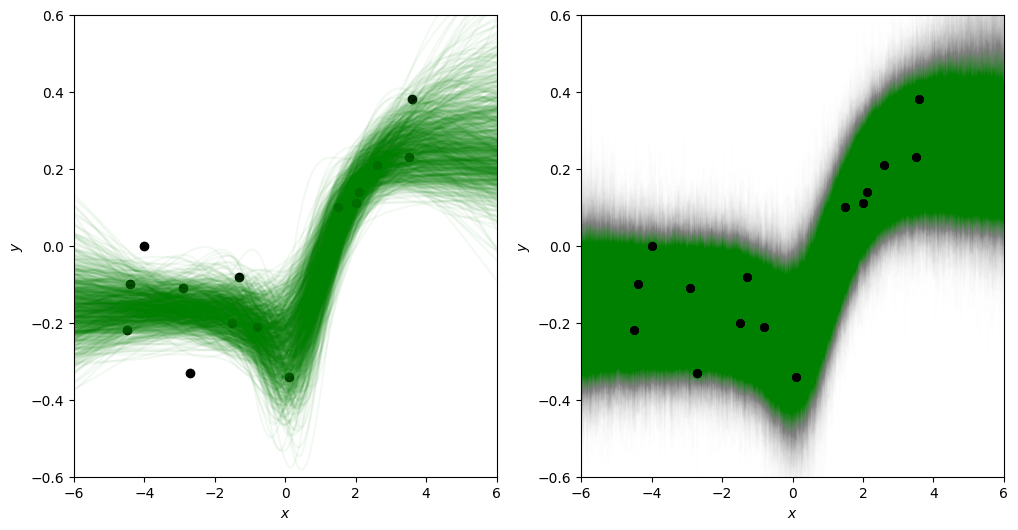

In [27]:
# 結果の図示
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for sample in mu_samples:
    ax[0].plot(x.flatten().numpy(), sample.detach().numpy(), alpha=0.05, color='g')
ax[0].scatter(x_data[:, 0].flatten().numpy(), y_data.numpy(), color="black")
ax[0].set(xlabel="$x$", ylabel="$y$", xlim=(-6.0, 6.0), ylim=(-0.6, 0.6))

for sample in y_samples:
    ax[1].plot(x.flatten().numpy(), sample.detach().numpy(), alpha=0.005, color='g')
ax[1].scatter(x_data[:, 0].flatten().numpy(), y_data.numpy(), color="black")
ax[1].set(xlabel="$x$", ylabel="$y$", xlim=(-6.0, 6.0), ylim=(-0.6, 0.6))
plt.show()